In [37]:
import time
import csv
from datetime import datetime,timedelta
import numpy as np

In [206]:
# [0:5] regular with period about 60, 
# [5:14] constant acceleration of about 12, 
# [14:20] constant deceleration of about 8,
# [20:24] regular with period about 30

timestamps = [0, 60.3, 121.1, 180.9, 241.9, 301.0, 307.3, 331.3, 366.9, 417.0, 478.7, 550.8, 632.6, 726.5, 831.6, 928.7, 1018.0, 1099.1, 1172.3, 1237.5, 1294.7, 1325.0, 1354.6, 1384.5, 1414.9]

In [207]:
n = len(timestamps)

diffs = np.zeros(n - 1)
diff_of_diffs = np.zeros(n - 2)

j = 0 # index of diffs
for i in range(n):
    if i+1 < n:
        diffs[j] = timestamps[i+1] - timestamps[i]
        j += 1
        
j = 0  # index of diff_of_diffs
for i in range(n - 1):
    if i+1 < n - 1:
        diff_of_diffs[j] = diffs[i+1] - diffs[i]
        j += 1

In [208]:
lam = 10 # hyperparameter

class Segment:
    start_index = 0
    end_index   = 0
    kind = "reg"
    value = 0
    
    def set_start_index(self, index):
        self.start_index = index
    def set_end_index(self, index):
        self.end_index = index
    def set_kind(self, kind):
        self.kind = kind
    def set_value(self, value):
        self.value = value

def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.
        
        
# Algorithm
partitions = [ [] for i in range(n)]
tot_error = np.zeros(n) # ith index contains total error of all partitions up to timestamp i

for i in range(n):
    if i == 0:
        tot_error[0] = lam
        
    if i == 1:
        segment = Segment()
        segment.set_start_index(0)
        segment.set_end_index(1)
        segment.set_kind("reg")
        segment.set_value(timestamps[1] - timestamps[0])
        partitions[1] = np.append(partitions[1], segment)
        tot_error[1] = lam
    
    else:
        minimizer = 0 # minimizing index of partition split
        min_cost = 0
        min_fit_kind = "."
        min_fit = 0
        for j in range(i):
            acc_fit = median(diff_of_diffs[j:i-2])
            if j == i-2:
                acc_fit = diff_of_diffs[i-2]
            reg_fit = median(diffs[j:i-1])
            if j == i-1:
                reg_fit = diffs[i-1]

            if acc_fit is float and abs(acc_fit) < 0.1:
                acc_fit = 0
            
            reg_error = 0
            for k in range(j, i):
                reg_error += abs(reg_fit-diffs[k])

            acc_error = 0
            if j != i-1:
                for k in range(j, i-1):
                    acc_error += abs(acc_fit-diff_of_diffs[k])
            else:
                acc_error = float("inf")

            if j == 0:
                if reg_error <= acc_error:
                    min_cost = reg_error + lam
                    min_fit_kind = "reg"
                    min_fit = reg_fit
                else:
                    min_cost = acc_error + lam
                    min_fit_kind = "acc"
                    min_fit = acc_fit
            else:
                if tot_error[j] + reg_error + lam <  min_cost:
                    minimizer = j
                    min_cost = tot_error[j] + reg_error + lam
                    min_fit_kind = "reg"
                    min_fit = reg_fit
                elif tot_error[j] + acc_error + lam <  min_cost:
                    minimizer = j
                    min_cost = tot_error[j] + acc_error + lam
                    min_fit_kind = "acc"
                    min_fit = acc_fit

        tot_error[i] = min_cost

        segment = Segment()
        segment.set_start_index(minimizer)
        segment.set_end_index(i)
        segment.set_kind(min_fit_kind)
        segment.set_value(min_fit)
        if minimizer == 0:
            partitions[i] = np.append(partitions[i], segment)
        else:
            partitions[i] = np.append(partitions[minimizer], segment)
        

In [219]:
partitions[n-1]

array([<__main__.Segment instance at 0x104fb1f38>,
       <__main__.Segment instance at 0x104fb1c20>,
       <__main__.Segment instance at 0x104fb1e18>,
       <__main__.Segment instance at 0x104ed26c8>], dtype=object)

Text(1324.75,0.02,'reg: 29.9')

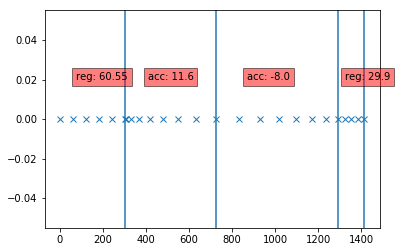

In [229]:
import matplotlib.pyplot as plt

%matplotlib inline

val = 0. # y-axis
plt.plot(timestamps, np.zeros_like(timestamps) + val, 'x')

plt.axvline(x=timestamps[partitions[n-1][0].end_index])
plt.axvline(x=timestamps[partitions[n-1][1].end_index])
plt.axvline(x=timestamps[partitions[n-1][2].end_index])
plt.axvline(x=timestamps[partitions[n-1][3].end_index])

first_loc = 0.75*timestamps[partitions[n-1][0].start_index]+0.25*timestamps[partitions[n-1][0].end_index]
second_loc = 0.75*timestamps[partitions[n-1][1].start_index]+0.25*timestamps[partitions[n-1][1].end_index]
third_loc = 0.75*timestamps[partitions[n-1][2].start_index]+0.25*timestamps[partitions[n-1][2].end_index]
fourth_loc = 0.75*timestamps[partitions[n-1][3].start_index]+0.25*timestamps[partitions[n-1][3].end_index]

first_text = partitions[n-1][0].kind + ": " + str(partitions[n-1][0].value)
second_text = partitions[n-1][1].kind + ": " + str(partitions[n-1][1].value)
third_text = partitions[n-1][2].kind + ": " + str(partitions[n-1][2].value)
fourth_text = partitions[n-1][3].kind + ": " + str(partitions[n-1][3].value)

plt.text(first_loc, 0.02, first_text, bbox=dict(facecolor='red', alpha=0.5))
plt.text(second_loc, 0.02, second_text, bbox=dict(facecolor='red', alpha=0.5))
plt.text(third_loc, 0.02, third_text, bbox=dict(facecolor='red', alpha=0.5))
plt.text(fourth_loc, 0.02, fourth_text, bbox=dict(facecolor='red', alpha=0.5))